In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
%matplotlib inline

# np.random.seed(42)

In [2]:
import os

folder = 'SimulatedDataset'
if not os.path.exists(folder):
    os.makedirs(folder) 

# S1

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]

T, dt, R = 3000, 0.1, 4
t = np.arange(T) * dt
downsample_factor = int(0.8 / 0.1)  # 8


# 1/f noise
def pink(T):
    X = np.fft.rfft(np.random.randn(T))
    S = np.sqrt(np.arange(len(X))+1)
    pink = np.fft.irfft(X/S)[:T]
    return pink / pink.std()
def hrf(t, tp, A, tu, au, a1, a2): 
    return A*(t/tp)**6*np.exp(-t/tp) - au*(t/tu)**6*np.exp(-t/tu)

# stimulus
possible_on = np.arange(20, T - 20, 10)
ons = np.random.choice(possible_on,12,False)
u0 = np.zeros(T)
for on in ons: 
    u0[on:on+20] = 1
u = np.tanh(gaussian_filter1d(u0,2)*2)*0.8

def spontaneous(T):
    n = [0.5 + 1.2*np.clip(gaussian_filter1d(np.random.randn(T),3) 
                      + 0.3*pink(T) + (u if i==0 else 0), 0, None) for i in range(R)]
    return n

def coupling(R):
    W = np.zeros((R,R))

    mask = np.zeros((R,R), dtype=bool)
    mask[~np.eye(R, dtype=bool)] = np.random.rand(R**2 - R) < 0.9
    W[mask] = np.random.uniform(0.2, 0.8, int(mask.sum()))
    W[~mask & ~np.eye(R, dtype=bool)] = np.random.uniform(-0.3, -0.1, (~mask & ~np.eye(R, dtype=bool)).sum())
    
    mask = np.random.rand(R) < 0.75
    selfconn = np.zeros(R)
    selfconn[mask] = np.random.uniform(-0.7, -0.3, mask.sum())
    np.fill_diagonal(W, selfconn)
    return W 
def delay(R): 
    D = np.random.uniform(0.5,3,(R,R))
    np.fill_diagonal(D, np.random.uniform(0.2, 1.2, R))
    d = (D/dt).astype(int)
    return d

def bold(x, R, theta):
    bold = []
    for i in range(R):
        h = hrf(t, theta[i][0], theta[i][1], theta[i][2], theta[i][3], theta[i][4], theta[i][5])
        y = convolve(x[i], h, 'same')*dt
        y = y / y.max() * np.random.uniform(0.8,2.5)
        bold += [100*(1 + y/100)]
    bold = np.array(bold)
    bold_ds = bold[:, ::downsample_factor]
    return bold_ds 

def S1(theta, T, dt, R): 
    noise = pink(T)
    n = spontaneous(T)
    W = coupling(R)
    d = delay(R)
    x = [ni.copy() for ni in n]
    for i in range(R):
        for j in range(R):
            if i!=j: 
                x[i][d[i,j]:] += W[i,j] * n[j][:-d[i,j] or None]
    BOLD_signal = bold(x, R, theta)    
    return x, BOLD_signal, W, d

# S2

In [4]:
from scipy.signal import find_peaks

def S2(x):
    timings   = np.zeros((R, 12))
    amplitudes= np.zeros((R, 12))
    widths    = np.zeros((R, 12))
    X = np.array(x)                                 # shape (4, 3000) from previous step
    for i in range(R):
        xi = X[i]
        # 1. Detect peaks
        prom = 0.5 * xi.std()
        dist = int(5 / dt)                        
        peaks, props = find_peaks(xi, prominence=prom, distance=dist,
                                  height=xi.mean(), width=0)
        
        n = min(len(peaks), 12)
        # 2. Extract properties
        t_peak = peaks[:n] * dt                     # seconds
        amp    = props['prominences'][:n]
        w      = props['widths'][:n] * dt           # seconds
        
        # 3. This part make the code look nicer =))))) because i'm a visual oriented person hihi
        timings[i, :n]    = t_peak
        amplitudes[i,:n]  = amp
        widths[i,:n]      = w
        if n < 12:
            shift = (12 - n) // 2
            timings[i]    = np.roll(timings[i],    shift)
            amplitudes[i] = np.roll(amplitudes[i], shift)
            widths[i]     = np.roll(widths[i],     shift)
            timings[i,:shift] = 0
            amplitudes[i,:shift] = 0
            widths[i,:shift] = 0
    return X, timings, amplitudes, widths 

# Dataset Simulation

→ Download: sample0.npz (Output tab)


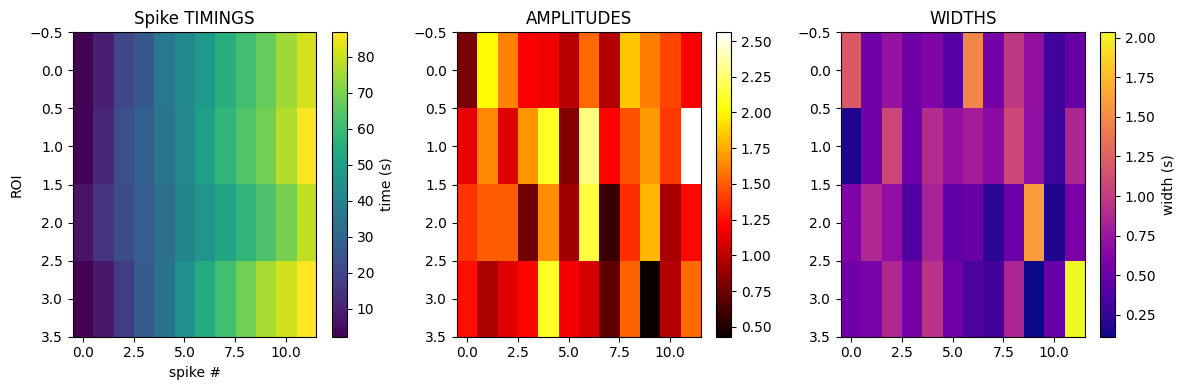

S2 DONE! 3×12 spike tables ready for any ML model.
Example ROI-1 spikes:
  # 1 →   2.7s  |  0.781  |  1.19s
  # 2 →   9.6s  |  2.007  |  0.53s
  # 3 →  20.2s  |  1.628  |  0.72s
  # 4 →  25.7s  |  1.200  |  0.52s
  # 5 →  36.0s  |  1.167  |  0.61s
  # 6 →  42.4s  |  0.980  |  0.40s
  # 7 →  47.9s  |  1.540  |  1.46s
  # 8 →  55.6s  |  0.968  |  0.55s
  # 9 →  61.3s  |  1.840  |  0.98s
  #10 →  66.9s  |  1.607  |  0.70s
  #11 →  74.8s  |  1.424  |  0.31s
  #12 →  81.3s  |  1.202  |  0.48s
ALGORITHM S1 – FULL GROUND TRUTH (1 subject)

1. BOLD signals b(t)
   ROI-1: max = 107.70
   ROI-2: max = 100.82
   ROI-3: max = 102.23
   ROI-4: max = 119.43

2. Neural activities x(t)
   Mean firing rates: [1.737 1.953 1.468 1.569]

3. Connectivity STRENGTH matrix W (4×4)
   (rows = target, columns = source)
[[-0.464  0.709  0.423  0.299]
 [ 0.785 -0.688  0.206  0.775]
 [ 0.659 -0.269 -0.529  0.639]
 [ 0.203  0.585  0.421 -0.676]]

4. Delay matrix D (seconds)
[[ 2  9 25  5]
 [24  4 11 13]
 [20 24  7 

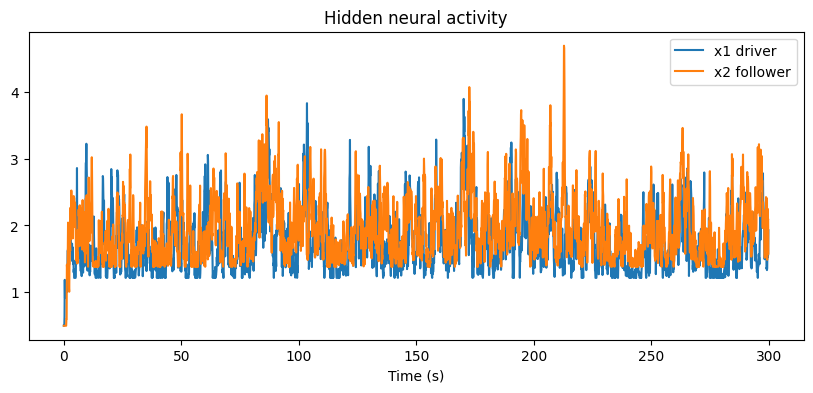

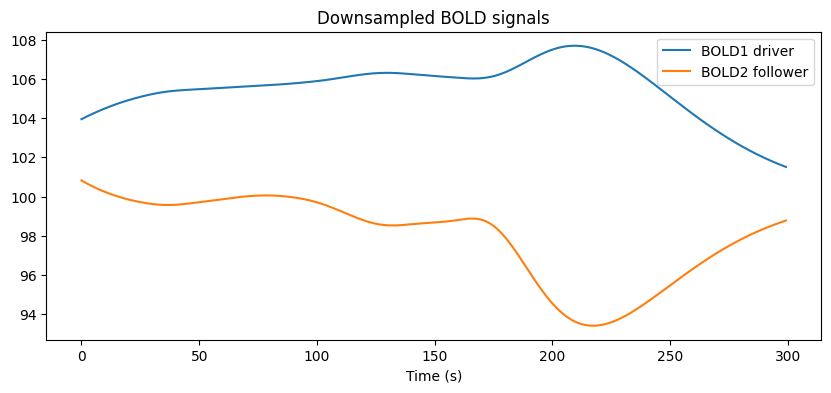

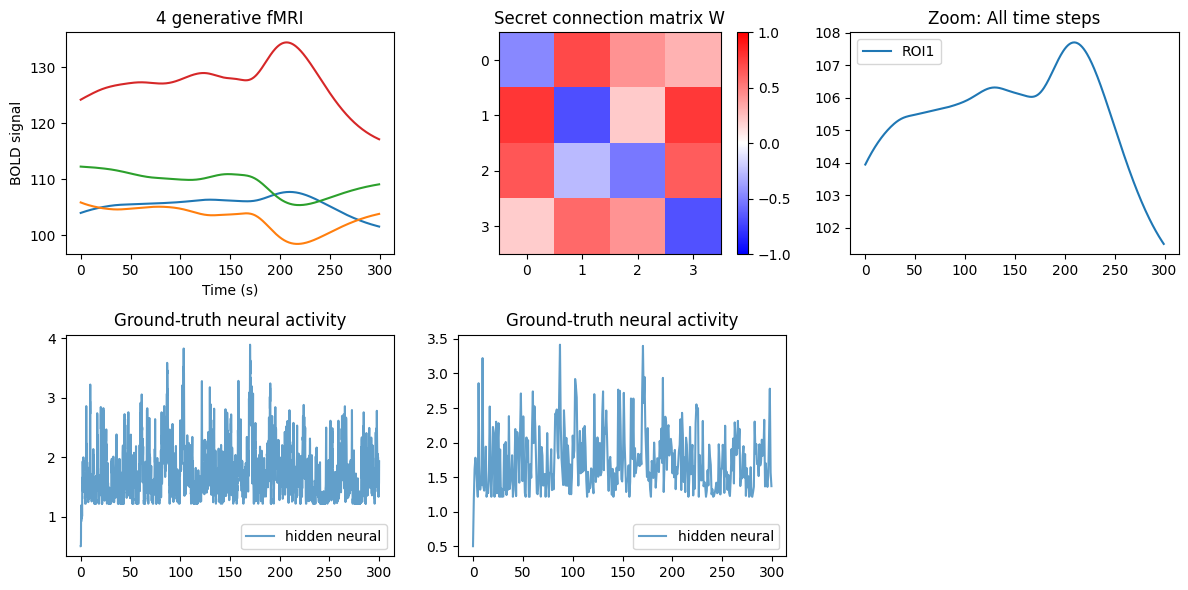

[[ 2  9 25  5]
 [24  4 11 13]
 [20 24  7 27]
 [10  5 28  5]]
→ Download: sample1.npz (Output tab)
→ Download: sample2.npz (Output tab)
→ Download: sample3.npz (Output tab)
→ Download: sample4.npz (Output tab)
→ Download: sample5.npz (Output tab)
→ Download: sample6.npz (Output tab)
→ Download: sample7.npz (Output tab)
→ Download: sample8.npz (Output tab)
→ Download: sample9.npz (Output tab)
→ Download: sample10.npz (Output tab)
→ Download: sample11.npz (Output tab)
→ Download: sample12.npz (Output tab)
→ Download: sample13.npz (Output tab)
→ Download: sample14.npz (Output tab)
→ Download: sample15.npz (Output tab)
→ Download: sample16.npz (Output tab)
→ Download: sample17.npz (Output tab)
→ Download: sample18.npz (Output tab)
→ Download: sample19.npz (Output tab)
→ Download: sample20.npz (Output tab)
→ Download: sample21.npz (Output tab)
→ Download: sample22.npz (Output tab)
→ Download: sample23.npz (Output tab)
→ Download: sample24.npz (Output tab)
→ Download: sample25.npz (Output tab

In [5]:
for s in range(1000): 
    np.random.seed(s)
    mean = np.array([6, 1.2, 15, 0.3, 6, 6])   # [tp, A, tu, au, a1, a2]
    theta = multivariate_normal.rvs(mean, np.eye(6)*0.3, R)
    
    x, BOLD, W, d = S1(theta, T, dt, R)
    X, timings, amplitudes, widths = S2(x)
    output = {
        'bold': BOLD.astype('f4'),
        'neural': X.astype('f4'),
        'W': W.astype('f4'),
        'D': d.astype('f4'),
        'theta': theta.astype('f4'),
        'timings': timings,
        'amplitudes': amplitudes,
        'widths': widths
    }
    np.savez_compressed(f'SimulatedDataset/sample{s}.npz', **output)
    print(f"→ Download: sample{s}.npz (Output tab)")
    if s == 0: 
        t_ds = t[::downsample_factor]
        x_ds = [xi[::downsample_factor] for xi in x] 
        # 1. Plot spike timings, amplitudes, widths
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(timings, cmap='viridis', aspect='auto')
        plt.colorbar(label='time (s)'); plt.title("Spike TIMINGS")
        plt.xlabel("spike #"); plt.ylabel("ROI")
        
        plt.subplot(1,3,2)
        plt.imshow(amplitudes, cmap='hot', aspect='auto')
        plt.colorbar(); plt.title("AMPLITUDES")
        
        plt.subplot(1,3,3)
        plt.imshow(widths, cmap='plasma', aspect='auto')
        plt.colorbar(label='width (s)'); plt.title("WIDTHS")
        plt.tight_layout(); plt.show()
        
        # 2. Print spike table for ROI-1
        print("S2 DONE! 3×12 spike tables ready for any ML model.")
        print("Example ROI-1 spikes:")
        for k in range(12):
            if amplitudes[0,k] > 0:
                print(f"  #{k+1:2d} → {timings[0,k]:5.1f}s  |  {amplitudes[0,k]:.3f}  |  {widths[0,k]:.2f}s")
        
        # 3. Print ground-truth summary
        print("="*60)
        print("ALGORITHM S1 – FULL GROUND TRUTH (1 subject)")
        print("="*60)
        print("\n1. BOLD signals b(t)")
        for r in range(R):
            print(f"   ROI-{r+1}: max = {BOLD[r].max():.2f}")
        
        print("\n2. Neural activities x(t)")
        print(f"   Mean firing rates: {np.mean(X, axis=1).round(3)}")
        
        print(f"\n3. Connectivity STRENGTH matrix W ({R}×{R})")
        print("   (rows = target, columns = source)")
        print(np.round(W, 3))
        
        print("\n4. Delay matrix D (seconds)")
        print(np.round(d, 2))
        
        print("\n5. HRF parameters θ (R×6)")
        print(theta)
        
        # 5. Mini causality demo
        plt.figure(figsize=(10,4))
        plt.plot(t, X[0], label='x1 driver')
        plt.plot(t, X[1], label='x2 follower')
        plt.legend(); plt.title("Hidden neural activity")
        plt.xlabel("Time (s)"); plt.show()
        
        plt.figure(figsize=(10,4))
        plt.plot(t_ds, BOLD[0], label='BOLD1 driver')
        plt.plot(t_ds, BOLD[1], label='BOLD2 follower')
        plt.legend(); plt.title("Downsampled BOLD signals")
        plt.xlabel("Time (s)"); plt.show()

        # Plot detail information
        plt.subplot(2,3,1)
        plt.plot(t_ds, BOLD.T + np.arange(R)*5)
        plt.title(f"{R} generative fMRI")
        plt.ylabel("BOLD signal"); plt.xlabel("Time (s)")
        
        plt.subplot(2,3,2)
        plt.imshow(W, cmap='bwr', vmin=-1, vmax=1)
        plt.colorbar(); plt.title("Secret connection matrix W")
        
        plt.subplot(2,3,3)
        plt.plot(t_ds[:375], BOLD[0,:375], label='ROI1'); plt.legend()
        plt.title("Zoom: All time steps")
        
        plt.subplot(2,3,4)
        plt.plot(t, x[0], alpha=.7, label='hidden neural'); plt.legend()
        plt.title("Ground-truth neural activity")

        plt.subplot(2,3,5)
        plt.plot(t_ds, x_ds[0], alpha=.7, label='hidden neural'); plt.legend()
        plt.title("Ground-truth neural activity")
        
        plt.tight_layout(); plt.show()
        print(np.round(d,2))
                

In [6]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/SimulatedDataset/ (stored 0%)
  adding: kaggle/working/SimulatedDataset/sample539.npz (deflated 1%)
  adding: kaggle/working/SimulatedDataset/sample133.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample872.npz (deflated 1%)
  adding: kaggle/working/SimulatedDataset/sample490.npz (deflated 1%)
  adding: kaggle/working/SimulatedDataset/sample559.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample134.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample665.npz (deflated 1%)
  adding: kaggle/working/SimulatedDataset/sample305.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample635.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample221.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample191.npz (deflated 2%)
  adding: kaggle/working/SimulatedDataset/sample152.npz (deflated 1%)
  adding: kaggle/working/SimulatedDataset/sample126.npz (deflated 1

In [7]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip